 This is the testing section of the model.
 This will be used to show how well the model works.

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import load_model
from datafunctions import convert_data, calc_rul, normalise, gen_sequence, gen_labels

np.random.seed(1010)
PYTHONHASHSEED = 0

model_path = "./finfanOUT/bin_model.h5"

# load the model
if os.path.isfile(model_path):
    estimator = load_model(model_path)


 Setup the testing data
 Currently just using training data because not enough data

In [2]:
# constant definitions take these from what the initial model was trained with
# the size of the blocks of data to be fed to the model, the larger the better
sequence_length = 50
# the number of days to predict failure within
w1 = pd.Timedelta(days=-30)
# scaler used
minmax_scaler = preprocessing.MinMaxScaler()
# below should be all input variables given to the model
# list of all sensors used
sensor_cols = ["speed"]
# list of other variables
sequence_cols = ["status"]
sequence_cols.extend(sensor_cols)

# Data input: Read in the data and add to a list, for further processing
test_df1 = pd.read_csv(
    "./finfanIN/Data_Extract_Train.txt", sep="\t", header=None, low_memory=False
)
test_df2 = pd.read_csv(
    "./finfanIn/Data_Extract_Train2.txt", sep="\t", header=None, low_memory=False
)
test_dfs = [test_df2]



In [3]:
# converts the list of training dataframes to the correct format and adds it a single dataframe with an id column
# it cleans the data and merges all the time columns, calculates time until failure (assumed last point in the input data)
# and normalises the data using the scaler chosen, by default uses minmax which scales it to between 0 and 1
test_df = None
for i, t in enumerate(test_dfs):
    if test_df is None:
        test_df = normalise(calc_rul(convert_data(t, i), w1), minmax_scaler)
    else:
        test_df = pd.concat(
            [test_df, normalise(calc_rul(convert_data(t, i), w1), minmax_scaler)],
            copy=False,
        )
print(test_df)


                      time   speed  status  id
0      2018-02-08 11:37:30  2086.0     0.0   0
1      2018-02-08 11:38:30  2085.0     0.0   0
2      2018-02-08 11:39:30  2086.0     0.0   0
3      2018-02-08 11:40:30  2085.0     0.0   0
4      2018-02-08 11:42:30  2086.0     0.0   0
...                    ...     ...     ...  ..
289615 2018-07-29 07:12:58    -3.0     1.0   0
289616 2018-07-29 15:04:29    -3.0     1.0   0
289617 2018-07-30 06:47:29    -3.0     1.0   0
289618 2018-07-30 09:36:29    -3.0     1.0   0
289619 2018-07-30 09:38:59    -3.0     1.0   0

[289620 rows x 4 columns]
                       time     speed  status  id                RUL  label1  \
0       1518089850000000000  0.993343     0.0   0 -14853689000000000       0   
1       1518089910000000000  0.992867     0.0   0 -14853629000000000       0   
2       1518089970000000000  0.993343     0.0   0 -14853569000000000       0   
3       1518090030000000000  0.992867     0.0   0 -14853509000000000       0   
4       1

In [4]:
# Pick the last sequence for each id

seq_array_test_last = [
    test_df[test_df["id"] == id][sequence_cols].values[-sequence_length:]
    for id in test_df["id"].unique()
    if len(test_df[test_df["id"] == id]) >= sequence_length
]
seq_array_test_last = np.asfarray(seq_array_test_last, dtype=np.float32)


# generate entire sequence
seq_gen = (
    list(gen_sequence(test_df[test_df["id"] == id], sequence_length, sequence_cols))
    for id in test_df["id"].unique()
)

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

In [5]:
# generate true labels for the input data
# last sequence
y_mask = [
    len(test_df[test_df["id"] == id]) >= sequence_length
    for id in test_df["id"].unique()
]
label_array_test_last = test_df.groupby("id")["label1"].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(
    label_array_test_last.shape[0], 1
).astype(np.float32)

# entire sequence
label_gen = [
    gen_labels(test_df[test_df["id"] == id], sequence_length, ["label1"])
    for id in test_df["id"].unique()
]
label_array = np.concatenate(label_gen).astype(np.float32)


In [6]:
# Testing the model, when using multiple testing datasets this is likely enough
# tests on the last chunk only
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
# results of test
print(f"Accuracy: {scores_test[1]}")
y_pred_test = (
    estimator.predict(seq_array_test_last, verbose=1, batch_size=200) > 0.5
).astype("int32")
y_true_test = label_array_test_last
print("Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels")
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)


1/1 - 2s - loss: 3.8694 - accuracy: 0.0000e+00
Accuracy: 0.0
1/1 [==============================] - 1s 659ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[0 0]
 [1 0]]


In [7]:
# Testing the model on the full data of a single id
# If wanting larger testing
scores_test = estimator.evaluate(seq_array, label_array, verbose=2)
# results of test
print(f"Accuracy: {scores_test[1]}")
y_pred_test = (estimator.predict(seq_array, verbose=1, batch_size=200) > 0.5).astype(
    "int32"
)
y_true_test = label_array
print("Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels")
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

9050/9050 - 36s - loss: 0.5314 - accuracy: 0.8359
Accuracy: 0.8358808159828186
1448/1448 [==============================] - 10s 7ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[ 61676  47307]
 [   217 180370]]


In [8]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print(
    "Precision: ",
    precision_test,
    "\n",
    "Recall: ",
    recall_test,
    "\n",
    "F1-score:",
    f1_test,
)


Precision:  0.7922188011964317 
 Recall:  0.9987983631158389 
 F1-score: 0.8835949287715792


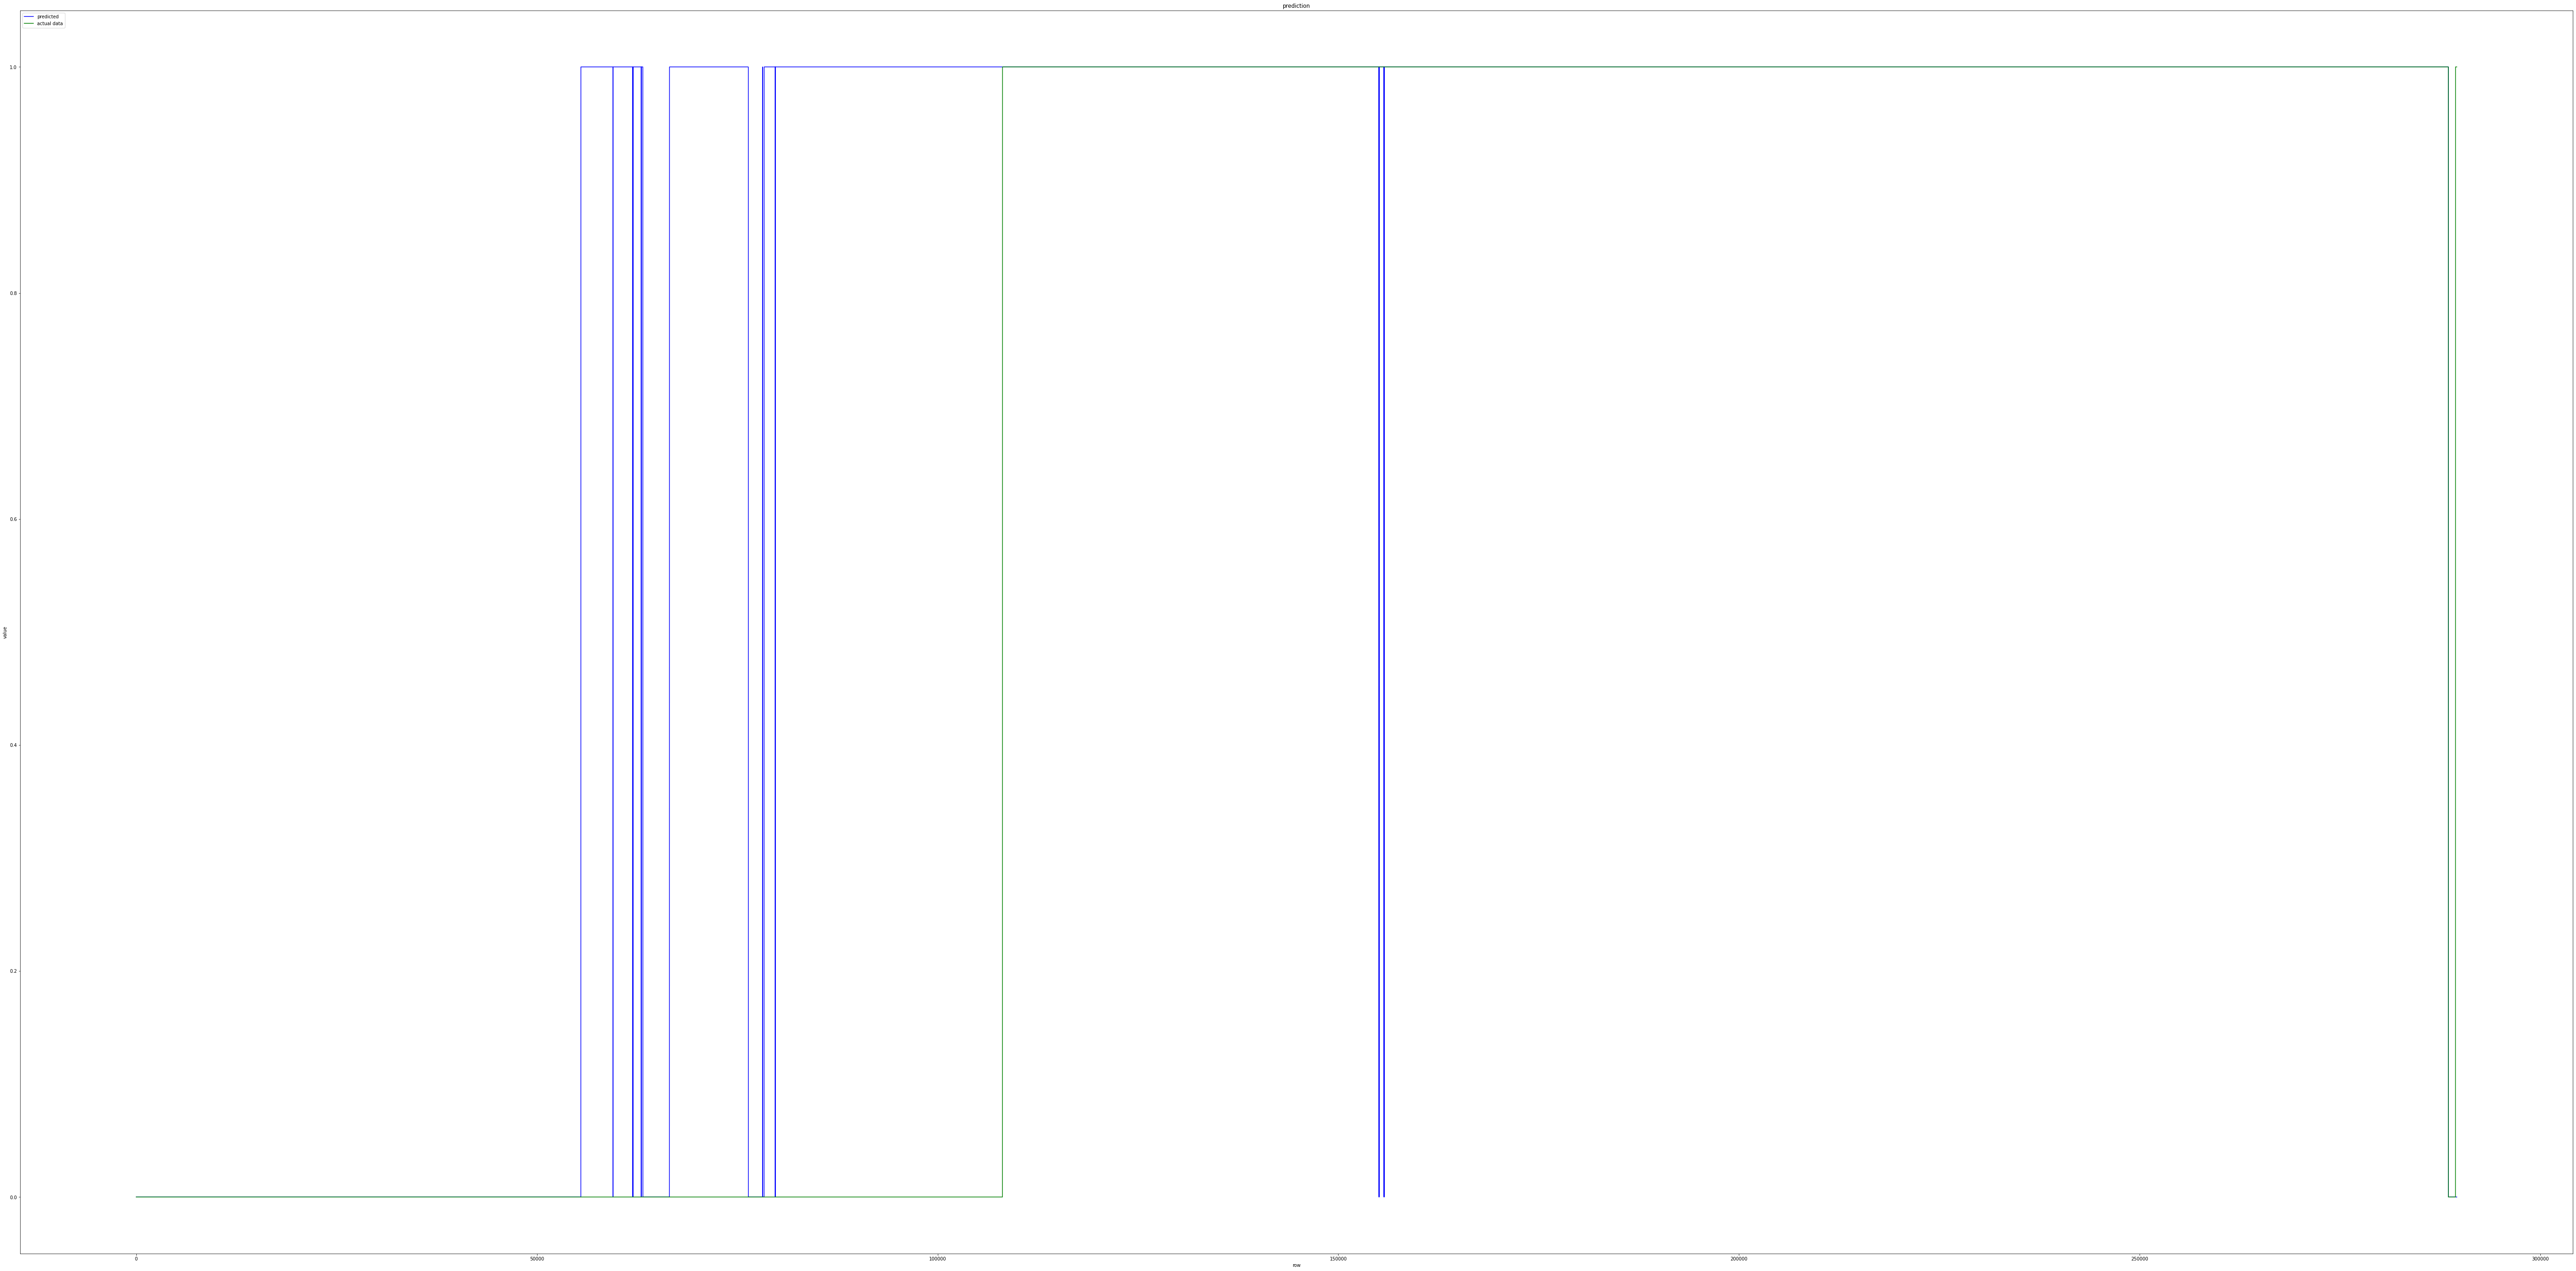

In [9]:
# Plot of accuracy of the model
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title("prediction")
plt.ylabel("value")
plt.xlabel("row")
plt.legend(["predicted", "actual data"], loc="upper left")
plt.show()
